# Import

In [2]:
import zipfile, os, glob ,re
import tifffile as tiff
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split


# Reading the data

In [3]:
ZIP_PATH = '/content/data-20250918T074311Z-1-001.zip'  # change to your actual path
EXTRACT_DIR = '/content/data'
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)

tif_paths = sorted(
    glob.glob(os.path.join(EXTRACT_DIR, '**', '*.tif'), recursive=True)
    + glob.glob(os.path.join(EXTRACT_DIR, '**', '*.tiff'), recursive=True)
)
print(f'Found {len(tif_paths)} TIFFs')

Found 306 TIFFs


In [4]:
MASKS_DIR = "/content/data/data/labels"

deleted = []
for path in glob.glob(os.path.join(MASKS_DIR, "*")):
    if "_" in os.path.splitext(os.path.basename(path))[0]:
        os.remove(path)
        deleted.append(os.path.basename(path))

print(f"Deleted {len(deleted)} masks with underscores.")
print("Examples:", deleted[:10])


Deleted 150 masks with underscores.
Examples: ['5_275.png', '22_16.png', '80_124.png', '15_233.png', '148_297.png', '93_217.png', '12_286.png', '10_244.png', '143_183.png', '96_154.png']


In [5]:
TIFS_DIR  = "/content/data/data/images"
tif_files = glob.glob(os.path.join(TIFS_DIR, "*.tif"))
mask_files = glob.glob(os.path.join(MASKS_DIR, "*.png")) + \
             glob.glob(os.path.join(MASKS_DIR, "*.tif"))

def index_by_id(files):
    mapping = {}
    for f in files:
        fid = os.path.splitext(os.path.basename(f))[0]
        if re.fullmatch(r"\d+", fid):
            mapping[fid] = f
    return mapping

tif_map  = index_by_id(tif_files)
mask_map = index_by_id(mask_files)

common_ids = sorted(set(tif_map) & set(mask_map))
pairs = [(tif_map[i], mask_map[i]) for i in common_ids]

print(f"Found {len(pairs)} image-mask pairs")
print("Example:")
for img, msk in pairs[:5]:
    print("Image:", img, " <->  Mask:", msk)


Found 306 image-mask pairs
Example:
Image: /content/data/data/images/0.tif  <->  Mask: /content/data/data/labels/0.png
Image: /content/data/data/images/1.tif  <->  Mask: /content/data/data/labels/1.png
Image: /content/data/data/images/10.tif  <->  Mask: /content/data/data/labels/10.png
Image: /content/data/data/images/100.tif  <->  Mask: /content/data/data/labels/100.png
Image: /content/data/data/images/101.tif  <->  Mask: /content/data/data/labels/101.png


In [6]:
import pandas as pd
df = pd.DataFrame(pairs, columns=["image", "mask"])

print(df.shape)
df.head()


(306, 2)


,image,mask
0,/content/data/data/images/0.tif,/content/data/data/labels/0.png
1,/content/data/data/images/1.tif,/content/data/data/labels/1.png
2,/content/data/data/images/10.tif,/content/data/data/labels/10.png
3,/content/data/data/images/100.tif,/content/data/data/labels/100.png
4,/content/data/data/images/101.tif,/content/data/data/labels/101.png


In [7]:
df_tr, val_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# Exploring the data

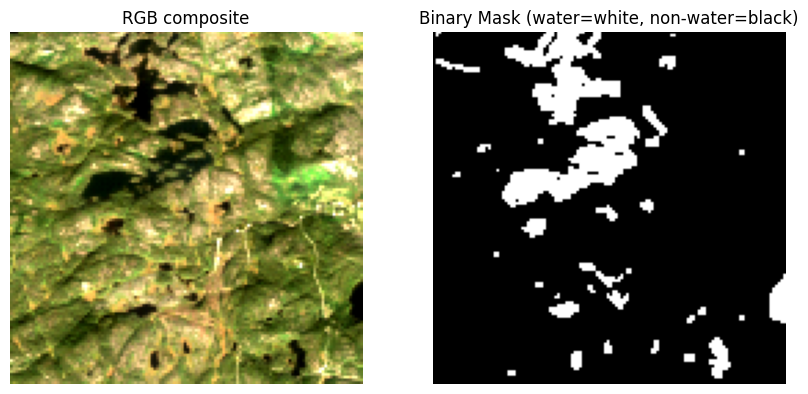

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_image_and_mask(image_path, mask_path, rgb_indices=(3,2,1)):
    # --- read multispectral image ---
    img = tiff.imread(image_path)  # (H, W, bands)

    # pick RGB channels
    rgb = img[:, :, list(rgb_indices)].astype(np.float32)

    # normalize for visualization
    rgb_min, rgb_max = np.percentile(rgb, (2, 98))
    rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

    # --- read mask in grayscale ---
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # ensure binary: water=1 (white), non-water=0 (black)
    mask_bin = (mask > 0).astype(np.uint8)

    # --- plot ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(rgb)
    ax[0].set_title("RGB composite")
    ax[0].axis("off")

    ax[1].imshow(mask_bin, cmap="gray")
    ax[1].set_title("Binary Mask (water=white, non-water=black)")
    ax[1].axis("off")

    plt.show()

# Example with the first sample
sample = df.iloc[0]
show_image_and_mask(sample["image"], sample["mask"])


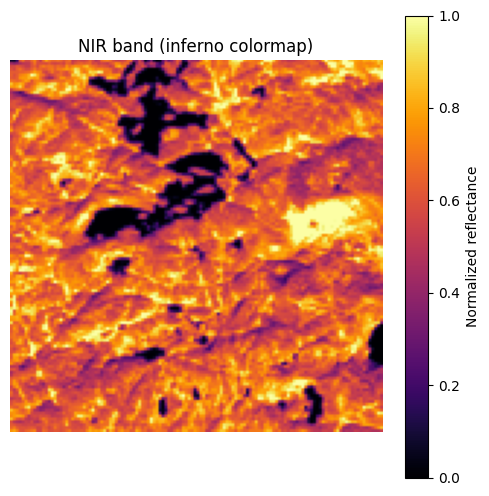

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

def show_nir_colored(image_path, nir_index=4, cmap="inferno"):
    # read image
    img = tiff.imread(image_path)  # shape = (H, W, bands)

    # select NIR band
    nir = img[:, :, nir_index].astype(np.float32)

    # normalize for display
    nir_min, nir_max = np.percentile(nir, (2, 98))
    nir_norm = np.clip((nir - nir_min) / (nir_max - nir_min), 0, 1)

    # plot with a colormap
    plt.figure(figsize=(6,6))
    plt.imshow(nir_norm, cmap=cmap)
    plt.title(f"NIR band ({cmap} colormap)")
    plt.axis("off")
    plt.colorbar(label="Normalized reflectance")
    plt.show()

# Example
sample = df.iloc[0]
show_nir_colored(sample["image"])


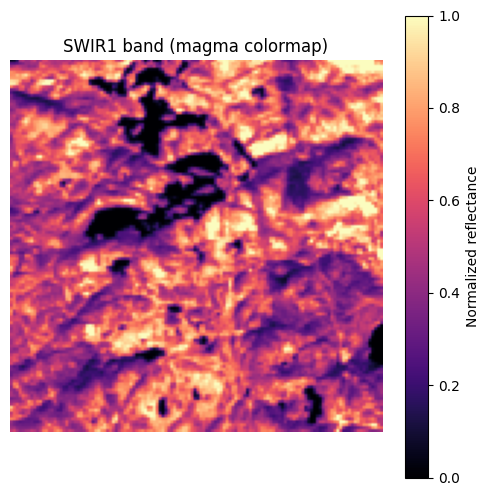

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

def show_swir1_colored(image_path, swir1_index=5, cmap="magma"):
    # read image
    img = tiff.imread(image_path)  # shape = (H, W, bands)

    # select SWIR1 band
    swir1 = img[:, :, swir1_index].astype(np.float32)

    # normalize for display
    swir1_min, swir1_max = np.percentile(swir1, (2, 98))
    swir1_norm = np.clip((swir1 - swir1_min) / (swir1_max - swir1_min), 0, 1)

    # plot
    plt.figure(figsize=(6,6))
    plt.imshow(swir1_norm, cmap=cmap)
    plt.title(f"SWIR1 band ({cmap} colormap)")
    plt.axis("off")
    plt.colorbar(label="Normalized reflectance")
    plt.show()

# Example
sample = df.iloc[0]
show_swir1_colored(sample["image"])


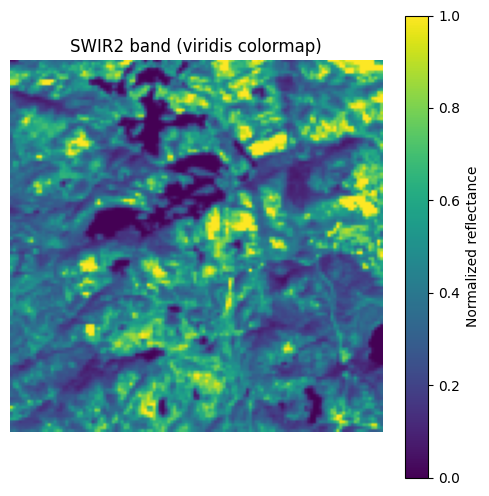

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

def show_swir2_colored(image_path, swir2_index=6, cmap="viridis"):
    # read image
    img = tiff.imread(image_path)  # shape = (H, W, bands)

    # select SWIR2 band
    swir2 = img[:, :, swir2_index].astype(np.float32)

    # normalize for display
    swir2_min, swir2_max = np.percentile(swir2, (2, 98))
    swir2_norm = np.clip((swir2 - swir2_min) / (swir2_max - swir2_min), 0, 1)

    # plot
    plt.figure(figsize=(6,6))
    plt.imshow(swir2_norm, cmap=cmap)
    plt.title(f"SWIR2 band ({cmap} colormap)")
    plt.axis("off")
    plt.colorbar(label="Normalized reflectance")
    plt.show()

# Example
sample = df.iloc[0]
show_swir2_colored(sample["image"])


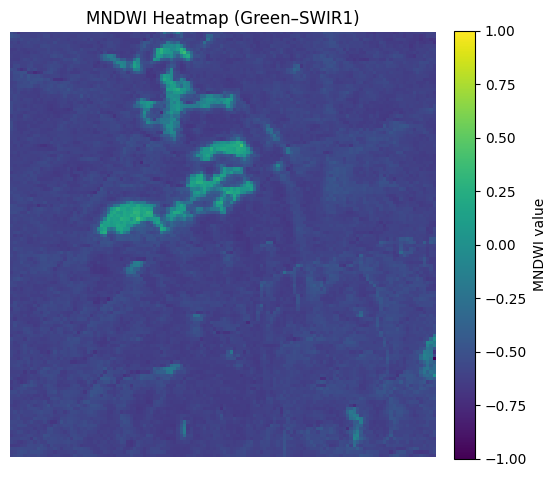

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

def ensure_hwc(arr):
    # make sure array is (H, W, C)
    if arr.ndim == 3 and arr.shape[0] < arr.shape[1] and arr.shape[0] < arr.shape[2]:
        return np.moveaxis(arr, 0, -1)
    return arr

def compute_mndwi(img, green_idx=2, swir1_idx=5, eps=1e-6):
    g     = img[:, :, green_idx].astype(np.float32)
    swir1 = img[:, :, swir1_idx].astype(np.float32)
    return np.clip((g - swir1) / (g + swir1 + eps), -1, 1)

def show_mndwi_heatmap(image_path, green_idx=2, swir1_idx=5, cmap="viridis"):
    # read multispectral image
    img = ensure_hwc(tiff.imread(image_path))

    # compute MNDWI
    mndwi = compute_mndwi(img, green_idx, swir1_idx)

    # plot heatmap
    plt.figure(figsize=(6,6))
    im = plt.imshow(mndwi, cmap=cmap, vmin=-1, vmax=1)
    plt.title("MNDWI Heatmap (Green–SWIR1)")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04, label="MNDWI value")
    plt.show()

# ---- Example usage ----
row = df.iloc[0]
show_mndwi_heatmap(row["image"], green_idx=2, swir1_idx=5, cmap="viridis")


# Preproccessing

In [8]:
def read_stack(path):
    arr = tiff.imread(path)
    if arr.ndim == 3 and arr.shape[0] < arr.shape[1]:
        arr = np.moveaxis(arr, 0, -1)
    return arr.astype(np.float32)

In [9]:
def compute_channel_minmax(df, channel_idx):
    channel_min, channel_max = float("inf"), float("-inf")

    for _, row in df.iterrows():
        stack = read_stack(row["image"])
        channel = stack[:, :, channel_idx].astype(np.float32)
        channel_min = min(channel_min, channel.min())
        channel_max = max(channel_max, channel.max())

    return channel_min, channel_max


In [10]:
def preprocess_channel(stack, channel_idx, channel_min=None, channel_max=None):
    """
    Min-max scale the channel to [0,1] using dataset-level min & max.
    """
    channel = stack[:, :, channel_idx].astype(np.float32)
    if channel_min is None or channel_max is None:
        raise ValueError("Please compute channel_min and channel_max first!")

    return (channel - channel_min) / (channel_max - channel_min )


In [13]:
nir_min, nir_max = compute_channel_minmax(df_tr, channel_idx=4)
print("NIR min:", nir_min, "NIR max:", nir_max)

stack = read_stack(df_tr.iloc[0]["image"])
nir_scaled = preprocess_channel(stack, channel_idx=4, channel_min=nir_min, channel_max=nir_max)

print("Scaled NIR range:", nir_scaled.min(), nir_scaled.max())


NIR min: -412.0 NIR max: 15841.0
Scaled NIR range: 0.05482065 0.29182306


In [14]:
swr1_min, swr1_max = compute_channel_minmax(df_tr, channel_idx=5)
print("SWR1 min:", swr1_min, "SWR1 max:", swr1_max)

stack = read_stack(df_tr.iloc[0]["image"])
swr1_scaled = preprocess_channel(stack, channel_idx=5, channel_min=swr1_min, channel_max=swr1_max)

print("Scaled SWR1 range:", swr1_scaled.min(), swr1_scaled.max())


SWR1 min: -335.0 SWR1 max: 15252.0
Scaled SWR1 range: 0.03971258 0.2980689


In [15]:
green_min, green_max = compute_channel_minmax(df_tr, channel_idx=2)
print("green min:", green_min, "green max:", green_max)

stack = read_stack(df_tr.iloc[0]["image"])
green_scaled = preprocess_channel(stack, channel_idx=2, channel_min=green_min, channel_max=green_max)

print("Scaled green range:", green_scaled.min(), green_scaled.max())


green min: -722.0 green max: 11368.0
Scaled green range: 0.08552523 0.2693962


In [16]:
swr2_min, swr2_max = compute_channel_minmax(df_tr, channel_idx=6)
print("SWR1 min:", swr1_min, "SWR1 max:", swr1_max)

stack = read_stack(df_tr.iloc[0]["image"])
swr2_scaled = preprocess_channel(stack, channel_idx=6, channel_min=swr2_min, channel_max=swr2_max)

print("Scaled SWR1 range:", swr2_scaled.min(), swr2_scaled.max())


SWR1 min: -335.0 SWR1 max: 15252.0
Scaled SWR1 range: 0.033277422 0.26413956


In [17]:
def preprocess_waterocc_channel(stack, occ_idx=11):
    """
    Preprocess Water Occurrence band by scaling from 0–100 → 0–1.
    """
    occ = stack[:, :, occ_idx].astype(np.float32)
    occ01 = occ / 100.0
    return occ01


In [18]:
stack = read_stack(df.iloc[0]["image"])
occ_scaled = preprocess_waterocc_channel(stack, occ_idx=11)

print("Scaled WaterOcc range:", occ_scaled.min(), occ_scaled.max())


Scaled WaterOcc range: 0.0 0.97


In [19]:
def compute_mndwi_from_scaled(green01, swir101, eps=1e-6):
    m = (green01 - swir101) / (green01 + swir101 + eps)
    return np.clip(m, -1.0, 1.0).astype(np.float32)

In [20]:
GREEN, NIR, SWR1, SWR2, OCC = 2, 4, 5, 6, 11
def build_input6_from_scaled(
    stack,
    green_min, green_max,
    nir_min, nir_max,
    swr1_min, swr1_max,
    swr2_min, swr2_max,
    occ_idx=11,
):

    green01 =  preprocess_channel(stack, GREEN, green_min, green_max)
    nir01   = preprocess_channel(stack, NIR,   nir_min,   nir_max)
    swr101  = preprocess_channel(stack, SWR1,  swr1_min,  swr1_max)
    swr201  = preprocess_channel(stack, SWR2,  swr2_min,  swr2_max)
    occ01   = preprocess_waterocc_channel(stack, occ_idx=occ_idx)

    # MNDWI from scaled bands
    mndwi = mndwi = compute_mndwi_from_scaled(green01, swr101)
    x6 = np.stack([mndwi, occ01, nir01, swr101, swr201, green01], axis=-1).astype(np.float32)
    return x6

# MODEL

In [ ]:
import numpy as np
import pandas as pd
import tifffile as tiff
import cv2


def read_mask(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return (m > 0).astype(np.float32)[...,None]


In [ ]:
import tensorflow as tf
def make_dataset(
    df,
    green_min, green_max,
    nir_min, nir_max,
    swr1_min, swr1_max,
    swr2_min, swr2_max,
    batch_size=16, shuffle=False
):
    X, Y = [], []
    for _, row in df.iterrows():
        st = read_stack(row["image"])
        x6 = build_input6_from_scaled(
            st,
            green_min, green_max,
            nir_min, nir_max,
            swr1_min, swr1_max,
            swr2_min, swr2_max,
            occ_idx=11
        )
        y  = read_mask(row["mask"])
        X.append(x6); Y.append(y)

    X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        ds = ds.shuffle(len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
train_ds = make_dataset(
    df_tr,
    green_min, green_max,
    nir_min, nir_max,
    swr1_min, swr1_max,
    swr2_min, swr2_max,
    batch_size=16, shuffle=True
)

val_ds = make_dataset(
    val_df,
    green_min, green_max,
    nir_min, nir_max,
    swr1_min, swr1_max,
    swr2_min, swr2_max,
    batch_size=16, shuffle=False
)


In [ ]:
from tensorflow.keras import layers, Model, Input

def unet_model(input_size=(128,128,6), base=32):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(base,3,activation='relu',padding='same')(inputs)
    c1 = layers.Conv2D(base,3,activation='relu',padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(base*2,3,activation='relu',padding='same')(p1)
    c2 = layers.Conv2D(base*2,3,activation='relu',padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(base*4,3,activation='relu',padding='same')(p2)
    c3 = layers.Conv2D(base*4,3,activation='relu',padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(base*8,3,activation='relu',padding='same')(p3)
    c4 = layers.Conv2D(base*8,3,activation='relu',padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(base*16,3,activation='relu',padding='same')(p4)
    c5 = layers.Conv2D(base*16,3,activation='relu',padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(base*8,2,strides=2,padding='same')(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = layers.Conv2D(base*8,3,activation='relu',padding='same')(u6)
    c6 = layers.Conv2D(base*8,3,activation='relu',padding='same')(c6)

    u7 = layers.Conv2DTranspose(base*4,2,strides=2,padding='same')(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(base*4,3,activation='relu',padding='same')(u7)
    c7 = layers.Conv2D(base*4,3,activation='relu',padding='same')(c7)

    u8 = layers.Conv2DTranspose(base*2,2,strides=2,padding='same')(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(base*2,3,activation='relu',padding='same')(u8)
    c8 = layers.Conv2D(base*2,3,activation='relu',padding='same')(c8)

    u9 = layers.Conv2DTranspose(base,2,strides=2,padding='same')(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(base,3,activation='relu',padding='same')(u9)
    c9 = layers.Conv2D(base,3,activation='relu',padding='same')(c9)

    outputs = layers.Conv2D(1,1,activation='sigmoid',dtype='float32')(c9)
    return Model(inputs, outputs)


In [ ]:
model = unet_model((128,128,6))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[ 'accuracy']
)
model.summary()

history = model.fit(train_ds, validation_data=val_ds, epochs=20)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 128, 128,  │      1,760 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_69[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_71[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ conv2d_72[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_73[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 16, 16,    │          0 │ conv2d_74[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_75[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 8, 8, 256) │          0 │ conv2d_76[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_15 │ (None, 16, 16,    │    524,544 │ conv2d_78[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_76[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,760,961 (29.61 MB)

 Trainable params: 7,760,961 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 539ms/step - accuracy: 0.8466 - loss: 0.5559 - val_accuracy: 0.9096 - val_loss: 0.2834
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8941 - loss: 0.3169 - val_accuracy: 0.9095 - val_loss: 0.2707
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8990 - loss: 0.2865 - val_accuracy: 0.9066 - val_loss: 0.2659
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8871 - loss: 0.3031 - val_accuracy: 0.9056 - val_loss: 0.2830
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8930 - loss: 0.2900 - val_accuracy: 0.9054 - val_loss: 0.2581
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8998 - loss: 0.2638 - val_accuracy: 0.9053 - val_loss: 0.2518
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8945 - loss: 0.2755 - val_accuracy: 0.9073 - val_loss: 0.2475
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9060 - loss: 0.2479 - val_accuracy: 0.9103 -

In [ ]:
loss, accuracy = model.evaluate(val_ds, steps=50)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9184 - loss: 0.2066 
Validation Loss: 0.20850017666816711
Validation Accuracy: 0.9173298478126526


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

y_true_all, y_pred_all = [], []
for Xb, Yb in val_ds:
    P = model.predict(Xb, verbose=0)
    y_true_all.append(Yb.numpy().ravel())
    y_pred_all.append((P > 0.5).astype(np.uint8).ravel())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print("F1:", f1_score(y_true_all, y_pred_all))
print("Precision:", precision_score(y_true_all, y_pred_all))
print("Recall:", recall_score(y_true_all, y_pred_all))


F1: 0.828594230616148
Precision: 0.9350374748363499
Recall: 0.7439087857153328


In [ ]:
import numpy as np

def evaluate_iou_over_ds(model, ds, thresh=0.5, eps=1e-7):
    inter_sum, union_sum = 0.0, 0.0
    for Xb, Yb in ds:
        P = model.predict(Xb, verbose=0)
        Yh = (P > thresh).astype(np.float32)
        Y  = Yb.numpy().astype(np.float32)

        inter = (Y * Yh).sum()
        union = (Y + Yh - Y*Yh).sum()
        inter_sum += inter
        union_sum += union
    return (inter_sum + eps) / (union_sum + eps)

iou_val = evaluate_iou_over_ds(model, val_ds, thresh=0.5)
print("Validation IoU:", round(float(iou_val), 4))


Validation IoU: 0.7074


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_masks(model, ds, n=3, thresh=0.5):
    """
    Visualize ground-truth vs predicted masks.

    model: trained Keras model
    ds: tf.data.Dataset yielding (X, y)
    n: number of samples to show
    thresh: binarization threshold
    """
    for Xb, Yb in ds.take(1):
        X = Xb.numpy()
        Y = Yb.numpy()
        P = model.predict(Xb, verbose=0)

        k = min(n, X.shape[0])
        for i in range(k):
            gt   = Y[i, ..., 0]                  # ground-truth mask
            prob = P[i, ..., 0]                  # predicted probability
            pred = (prob >= thresh).astype(np.float32)  # binary mask

            fig, ax = plt.subplots(1, 2, figsize=(6, 3))
            ax[0].imshow(gt, cmap="gray")
            ax[0].set_title("Ground Truth")
            ax[0].axis("off")

            ax[1].imshow(pred, cmap="gray")
            ax[1].set_title("Predicted Mask")
            ax[1].axis("off")

            plt.tight_layout()
            plt.show()


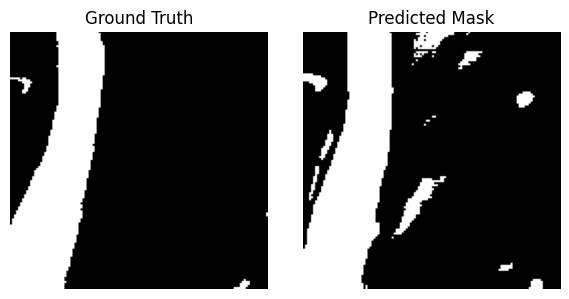

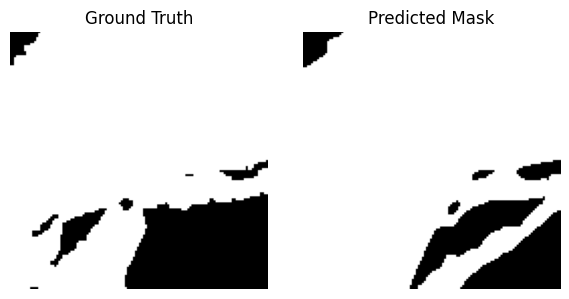

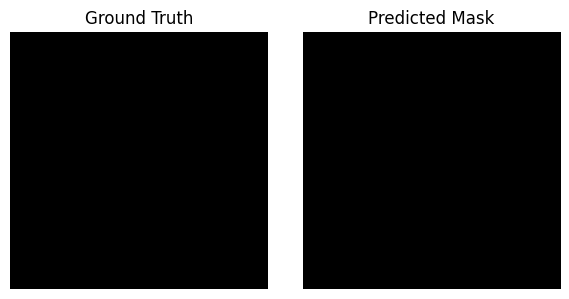

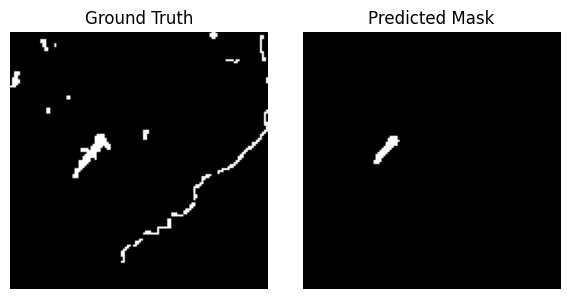

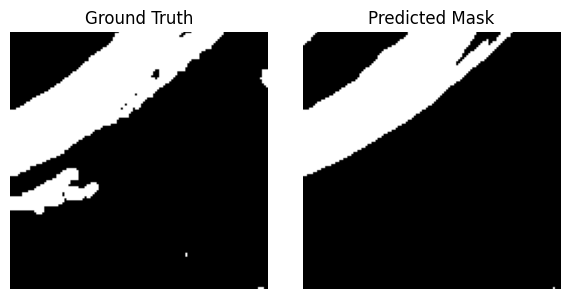

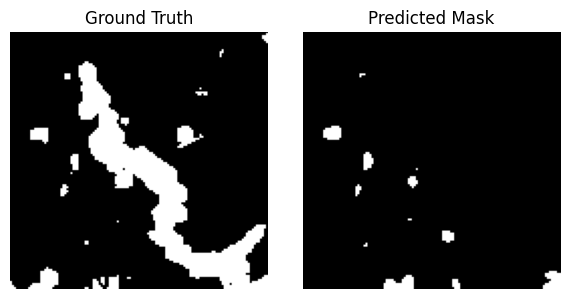

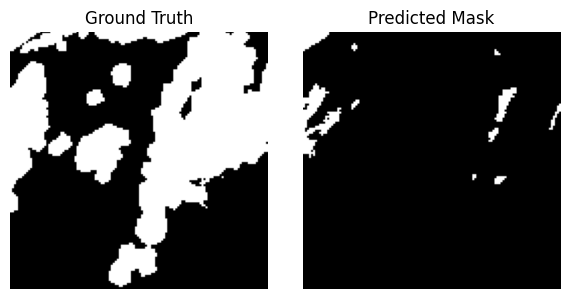

In [ ]:
show_masks(model, val_ds, n=7, thresh=0.5)


# Pretrained model


In [15]:
!pip install segmentation_models_pytorch

In [16]:
!pip install torchgeo

In [36]:
import torch

cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')


try:
    from torch.amp import autocast, GradScaler
except Exception:
    from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler(enabled=cuda)


In [37]:
import numpy as np, torch, tifffile as tiff, imageio.v2 as iio
from torch.utils.data import Dataset


IDX = {
    "coastal":0, "blue":1, "green":2, "red":3, "nir":4, "swir1":5, "swir2":6,
    "qa":7, "merit_dem":8, "cop_dem":9, "worldcover":10, "water_occ":11
}

class WaterSegDatasetMNDWI(Dataset):
    def __init__(self, df, bin_threshold=0.5):
        self.df = df.reset_index(drop=True)
        self.bin_threshold = bin_threshold

    def __len__(self): return len(self.df)

    def _read_stack_plus_mndwi(self, path):
        arr = tiff.imread(path)
        if arr.ndim == 2: arr = arr[..., None]
        if arr.ndim == 3 and arr.shape[0] <= 12 and arr.shape[0] < arr.shape[-1]:
            arr = np.transpose(arr, (1, 2, 0))
        arr = arr.astype(np.float32)


        G  = arr[..., IDX["green"]]
        S1 = arr[..., IDX["swir1"]]
        mndwi = (G - S1) / (G + S1 + 1e-6)
        mndwi = np.clip(mndwi, -1.0, 1.0)


        arr13 = np.concatenate([arr, mndwi[..., None]], axis=-1)


        spec_dem_mndwi_idx = [IDX["coastal"], IDX["blue"], IDX["green"], IDX["red"],
                              IDX["nir"], IDX["swir1"], IDX["swir2"],
                              IDX["merit_dem"], IDX["cop_dem"], 12]
        x = arr13[..., spec_dem_mndwi_idx]
        p2  = np.percentile(x,  2, axis=(0,1), keepdims=True)
        p98 = np.percentile(x, 98, axis=(0,1), keepdims=True)
        x   = np.clip((x - p2) / (p98 - p2 + 1e-6), 0, 1)
        arr13[..., spec_dem_mndwi_idx] = x

        qa = arr13[..., IDX["qa"]]
        if qa.max() > 1.0: qa = qa / qa.max()
        arr13[..., IDX["qa"]] = qa


        wc = arr13[..., IDX["worldcover"]]
        wc_water = (wc == 80).astype(np.float32)
        arr13[..., IDX["worldcover"]] = wc_water


        wocc = arr13[..., IDX["water_occ"]]
        if wocc.max() > 1.0: wocc = wocc / 100.0
        arr13[..., IDX["water_occ"]] = np.clip(wocc, 0, 1)


        arr13 = np.transpose(arr13, (2, 0, 1))
        return torch.from_numpy(arr13)

    def _read_mask(self, path):
        m = iio.imread(path)
        if m.ndim == 3: m = m[..., 0]
        m = m.astype(np.float32)
        if m.max() > 1.0: m /= 255.0
        m = (m > self.bin_threshold).astype(np.float32)
        return torch.from_numpy(m[None, ...])

    def __getitem__(self, idx):
        x = self._read_stack_plus_mndwi(self.df.loc[idx, "image"])
        y = self._read_mask(self.df.loc[idx, "mask"])
        return x, y


In [38]:
from torch.utils.data import DataLoader
import torch

cuda = torch.cuda.is_available()
train_ds = WaterSegDatasetMNDWI(df_tr)
val_ds   = WaterSegDatasetMNDWI(val_df)


BATCH_SIZE = 2
NUM_WORKERS = 0

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=cuda,
    drop_last=False,
    persistent_workers=False if NUM_WORKERS == 0 else True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=cuda,
    drop_last=False,
    persistent_workers=False if NUM_WORKERS == 0 else True,
)

xb, yb = next(iter(train_loader))
print("Train batch shapes:", xb.shape, yb.shape)


Train batch shapes: torch.Size([2, 13, 128, 128]) torch.Size([2, 1, 128, 128])


In [64]:

import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=13,
    classes=1
)


model = model.to(device)



In [65]:
from torchgeo.models import ResNet18_Weights
import segmentation_models_pytorch as smp
import torch

enc_sd = model.encoder.state_dict()
uses_layer0 = any(k.startswith("layer0.") for k in enc_sd.keys())
stem_prefix = "layer0." if uses_layer0 else ""


tg_sd = ResNet18_Weights.SENTINEL2_ALL_MOCO.get_state_dict(progress=True)

def map_torchgeo_to_smp(sd, stem_prefix):
    mapped = {}
    for k, v in sd.items():
        if k.startswith("fc."):
            continue
        if k.startswith(("conv1.", "bn1.")):
            mapped[stem_prefix + k] = v
        else:
            mapped[k] = v
    return mapped

mapped_sd = map_torchgeo_to_smp(tg_sd, stem_prefix)

target_key = stem_prefix + "conv1.weight"
target_cin = enc_sd[target_key].shape[1]
w = mapped_sd.get(target_key, None)
if w is not None and w.shape[1] != target_cin:
    with torch.no_grad():
        mapped_sd[target_key] = w.mean(1, True).repeat(1, target_cin, 1, 1)

model.encoder.load_state_dict(mapped_sd, strict=False)

enc_keys   = set(model.encoder.state_dict().keys())
ckpt_keys  = set(mapped_sd.keys())
missing    = sorted(enc_keys - ckpt_keys)
unexpected = sorted(ckpt_keys - enc_keys)
print("First conv shape:", model.encoder.state_dict()[target_key].shape)  # expect [64, 13, 7, 7]
print("Missing:", missing[:10])
print("Unexpected:", unexpected[:10])


First conv shape: torch.Size([64, 13, 7, 7])
Missing: []
Unexpected: []


In [66]:
import numpy as np
try:
    from torch.amp import autocast
except Exception:
    from torch.cuda.amp import autocast

def evaluate_iou_f1_over_loader(model, loader, device, cuda, thr=0.5, eps=1e-6):
    model.eval()
    ious, f1s = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, dtype=torch.float32, non_blocking=cuda)
            yb = yb.to(device, dtype=torch.float32, non_blocking=cuda)
            with autocast('cuda', enabled=cuda):
                p = model(xb).sigmoid()
            yhat = (p > thr).float()

            inter = (yhat * yb).sum((1,2,3))
            union = yhat.sum((1,2,3)) + yb.sum((1,2,3)) - inter
            iou = ((inter+eps)/(union+eps))

            tp = inter
            fp = (yhat * (1 - yb)).sum((1,2,3))
            fn = ((1 - yhat) * yb).sum((1,2,3))
            precision = (tp+eps)/(tp+fp+eps)
            recall    = (tp+eps)/(tp+fn+eps)
            f1 = (2*precision*recall)/(precision+recall+eps)

            ious.append(iou.mean().item())
            f1s.append(f1.mean().item())
    return float(np.mean(ious)), float(np.mean(f1s))

def find_best_threshold(model, val_loader, device, cuda, metric="iou"):
    thrs = np.linspace(0.20, 0.80, 13)
    best_thr, best_val = 0.5, -1.0
    for t in thrs:
        iou, f1 = evaluate_iou_f1_over_loader(model, val_loader, device, cuda, thr=t)
        val = iou if metric.lower() == "iou" else f1
        if val > best_val:
            best_val, best_thr = val, t
    return best_thr, best_val


In [67]:
dice = smp.losses.DiceLoss(mode="binary")
bce  = smp.losses.SoftBCEWithLogitsLoss()

def bce_dice(logits, y): return 0.5*bce(logits, y) + 0.5*dice(logits, y)

def iou_from_logits(logits, y, thr=0.5, eps=1e-6):
    yhat = (logits.sigmoid() > thr).float()
    inter = (yhat*y).sum(dim=(1,2,3))
    union = yhat.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) - inter
    return ((inter+eps)/(union+eps)).mean().item()

def f1_from_logits(logits, y, thr=0.5, eps=1e-6):
    yhat = (logits.sigmoid() > thr).float()
    tp = (yhat*y).sum(dim=(1,2,3))
    fp = (yhat*(1-y)).sum(dim=(1,2,3))
    fn = ((1-yhat)*y).sum(dim=(1,2,3))
    precision = (tp+eps)/(tp+fp+eps)
    recall    = (tp+eps)/(tp+fn+eps)
    f1 = (2*precision*recall)/(precision+recall+eps)
    return f1.mean().item()

opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

In [68]:
import json, matplotlib.pyplot as plt

# ---------- histories ----------
tr_loss_hist, tr_iou_hist, tr_f1_hist = [], [], []
vl_loss_hist, vl_iou_hist, vl_f1_hist = [], [], []

EPOCHS = 50
best_iou = -1.0
os.makedirs("checkpoints", exist_ok=True)
best_ckpt   = "checkpoints/unet_resnet18_bce_dice_best.pth"
last_ckpt   = "checkpoints/unet_resnet18_bce_dice_last.pth"
history_json = "checkpoints/train_history.json"

for epoch in range(1, EPOCHS + 1):
    # ===== Train =====
    model.train()
    tr_loss = tr_iou = tr_f1 = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device, dtype=torch.float32, non_blocking=cuda)
        yb = yb.to(device, dtype=torch.float32, non_blocking=cuda)

        opt.zero_grad(set_to_none=True)
        with autocast('cuda', enabled=cuda):
            logits = model(xb)
            loss   = bce_dice(logits, yb)

        if cuda:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward(); opt.step()

        tr_loss += loss.item() * xb.size(0)
        tr_iou  += iou_from_logits(logits.detach(), yb)
        tr_f1   += f1_from_logits (logits.detach(), yb)

    tr_loss /= len(train_ds)
    tr_iou  /= max(1, len(train_loader))
    tr_f1   /= max(1, len(train_loader))

    # ===== Val =====
    model.eval()
    vl_loss = vl_iou = vl_f1 = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, dtype=torch.float32, non_blocking=cuda)
            yb = yb.to(device, dtype=torch.float32, non_blocking=cuda)
            with autocast('cuda', enabled=cuda):
                logits = model(xb)
                loss   = bce_dice(logits, yb)
            vl_loss += loss.item() * xb.size(0)
            vl_iou  += iou_from_logits(logits, yb)
            vl_f1   += f1_from_logits (logits, yb)

    vl_loss /= len(val_ds)
    vl_iou  /= max(1, len(val_loader))
    vl_f1   /= max(1, len(val_loader))

    # ---- record history ----
    tr_loss_hist.append(tr_loss); tr_iou_hist.append(tr_iou); tr_f1_hist.append(tr_f1)
    vl_loss_hist.append(vl_loss); vl_iou_hist.append(vl_iou); vl_f1_hist.append(vl_f1)

    # ---- save best & last checkpoints ----
    if vl_iou > best_iou:
        best_iou = vl_iou
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": opt.state_dict(),
            "scaler_state": scaler.state_dict() if cuda else None,
            "val_iou": vl_iou,
        }, best_ckpt)

    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": opt.state_dict(),
        "scaler_state": scaler.state_dict() if cuda else None,
        "val_iou": vl_iou,
    }, last_ckpt)

    print(f"Epoch {epoch:02d} | "
          f"train_loss {tr_loss:.4f} IoU {tr_iou:.3f} F1 {tr_f1:.3f} | "
          f"val_loss {vl_loss:.4f} IoU {vl_iou:.3f} F1 {vl_f1:.3f} | "
          f"best_IoU {best_iou:.3f}")

# ---- save history to JSON (optional) ----
with open(history_json, "w") as f:
    json.dump({
        "tr_loss": tr_loss_hist, "tr_iou": tr_iou_hist, "tr_f1": tr_f1_hist,
        "vl_loss": vl_loss_hist, "vl_iou": vl_iou_hist, "vl_f1": vl_f1_hist,
    }, f)

print(f"Saved best: {best_ckpt}\nSaved last: {last_ckpt}\nSaved history: {history_json}")


Epoch 01 | train_loss 0.5381 IoU 0.345 F1 0.443 | val_loss 0.4122 IoU 0.488 F1 0.565 | best_IoU 0.488
Epoch 02 | train_loss 0.4314 IoU 0.407 F1 0.505 | val_loss 0.3825 IoU 0.522 F1 0.596 | best_IoU 0.522
Epoch 03 | train_loss 0.4004 IoU 0.422 F1 0.518 | val_loss 0.3700 IoU 0.440 F1 0.528 | best_IoU 0.522
Epoch 04 | train_loss 0.3795 IoU 0.451 F1 0.542 | val_loss 0.3724 IoU 0.501 F1 0.587 | best_IoU 0.522
Epoch 05 | train_loss 0.3545 IoU 0.464 F1 0.557 | val_loss 0.3495 IoU 0.540 F1 0.630 | best_IoU 0.540
Epoch 06 | train_loss 0.3299 IoU 0.508 F1 0.599 | val_loss 0.3383 IoU 0.561 F1 0.652 | best_IoU 0.561
Epoch 07 | train_loss 0.3468 IoU 0.521 F1 0.616 | val_loss 0.3445 IoU 0.524 F1 0.615 | best_IoU 0.561
Epoch 08 | train_loss 0.3011 IoU 0.492 F1 0.583 | val_loss 0.3331 IoU 0.563 F1 0.646 | best_IoU 0.563
Epoch 09 | train_loss 0.3010 IoU 0.514 F1 0.604 | val_loss 0.3009 IoU 0.589 F1 0.677 | best_IoU 0.589
Epoch 10 | train_loss 0.2850 IoU 0.526 F1 0.615 | val_loss 0.2944 IoU 0.595 F1 0.6

In [77]:
best_thr, best_iou = find_best_threshold(model, val_loader, device, cuda, metric="iou")

In [78]:
print(f"Best threshold on val: {best_thr:.2f}  |  IoU@best_thr = {best_iou:.3f}")

Best threshold on val: 0.30  |  IoU@best_thr = 0.732


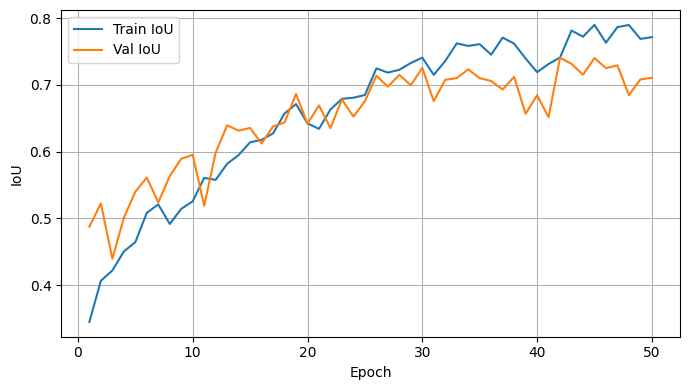

In [70]:
epochs = range(1, len(tr_iou_hist)+1)
plt.figure(figsize=(7,4))
plt.plot(epochs, tr_iou_hist, label="Train IoU")
plt.plot(epochs, vl_iou_hist, label="Val IoU")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig("checkpoints/iou_curve.png", dpi=150)
plt.show()


In [71]:
import random, numpy as np, torch, matplotlib.pyplot as plt

def show_random_preds(model, dataset, n=3, device=None, thr=0.5):
    """
    Pick n random items from `dataset`, run the model, and plot GT vs Pred.
    dataset must return (x:[C,H,W], y:[1,H,W]).
    """
    device = device or next(model.parameters()).device
    model.eval()

    idxs = random.sample(range(len(dataset)), n)
    fig, axes = plt.subplots(n, 2, figsize=(8, 3*n))
    if n == 1:
        axes = np.array([axes])

    with torch.no_grad():
        for r, i in enumerate(idxs):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device, dtype=torch.float32)
            p = model(x).sigmoid().cpu()[0, 0].numpy()
            gt = y[0].numpy()
            pr = (p > thr).astype(float)

            axes[r, 0].imshow(gt, cmap="gray");  axes[r, 0].set_title(f"GT (idx {i})"); axes[r, 0].axis("off")
            axes[r, 1].imshow(pr, cmap="gray");  axes[r, 1].set_title(f"Pred (thr={thr:.2f})"); axes[r, 1].axis("off")

    plt.tight_layout()
    plt.show()


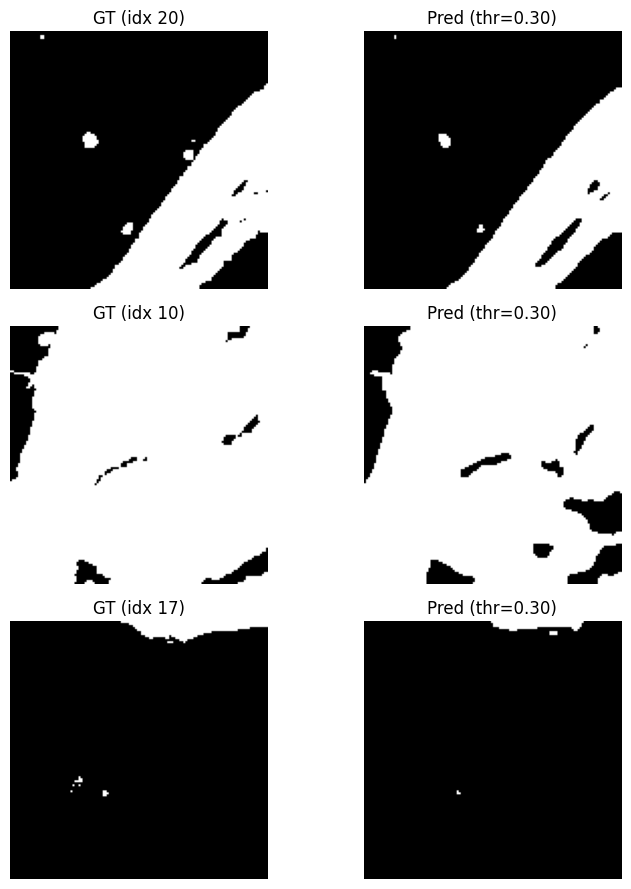

In [83]:
show_random_preds(model, val_ds, n=3, device=device, thr=best_thr)
